In [1]:
#Loading necessary libraries for the project at hand
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, GlobalAveragePooling2D,BatchNormalization
import os
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint
#from sklearn import model

In [2]:
#Data Pre-Processing
b_dir = ".../Users/Alzheimer/"
r_dir = "./"
test_dir = b_dir + "test/"
train_dir = b_dir + "train/"
w_dir = r_dir + "dataset/"
if os.path.exists(w_dir):
    remove_tree(w_dir)
os.mkdir(w_dir)
copy_tree(train_dir, w_dir)
copy_tree(test_dir, w_dir)
print("Working Directory Contents:", os.listdir(w_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [3]:
#Azure credential and Synthea Datasets
#blob = BlobClient(account_url="https://xxxxx.blob.core.windows.net",
#                  container_name="dicom",
#                  blob_name="nondemented.zip",
#                 credential="yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy")

In [4]:
#Open dataset
#with open("nondemented.zip", "wb") as a:
#    data = blob.download_blob()
#    data.readinto(a)

In [6]:
#Classes and Image dimensions
W_DIR = './dataset/'
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [7]:
#Performing Image Augmentation to have more data samples
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = work_dr.flow_from_directory(directory=W_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


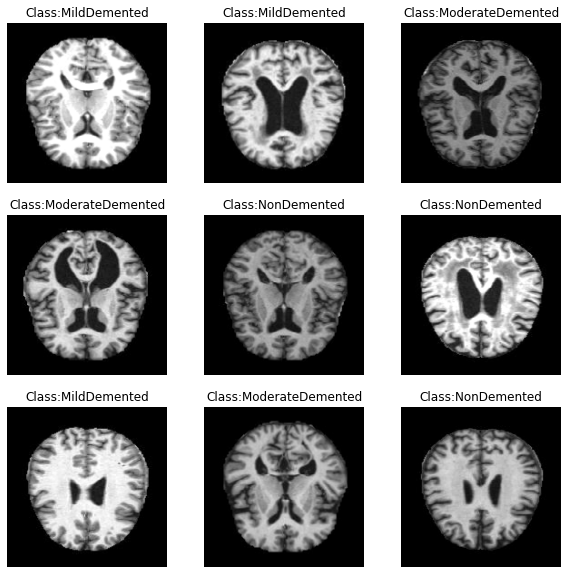

In [8]:
#Sample Images
def show_images(generator,y_pred=None):
    """Input: An image generator,predicted labels (optional) Output: Displays a grid of 9 images with lables"""
   # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
   # get a batch of images
    x,y = generator.next()
   # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
# Display Train Images
show_images(train_data_gen)

In [9]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()

In [10]:
#Getting to know the dimensions of our dataset
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [11]:
#Performing over-sampling of the data, since the classes are imbalanced
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [12]:
#Splitting the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [13]:
#Using the InceptionV3 model as a base model for the task
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [14]:
for layer in inception_model.layers:
    layer.trainable=False

In [15]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [16]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
my_callback = MyCallback()
#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [17]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]
CALLBACKS = [my_callback, rop_callback]
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

In [ ]:
#Fit the training data to the model and validate it using the validation data
#Use higher EPOCHS in production to get better accuracy
EPOCHS = 45
history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
256/256 [==============================] - 177s 694ms/step - loss: 0.5218 - acc: 0.7883 - auc: 0.9519 - f1_score: 0.7875 - val_loss: 0.4203 - val_acc: 0.8208 - val_auc: 0.9674 - val_f1_score: 0.8207 - lr: 0.0010
Epoch 2/100
256/256 [==============================] - 846s 3s/step - loss: 0.5038 - acc: 0.7904 - auc: 0.9550 - f1_score: 0.7895 - val_loss: 0.4251 - val_acc: 0.8149 - val_auc: 0.9668 - val_f1_score: 0.8139 - lr: 0.0010
Epoch 3/100
256/256 [==============================] - 251s 984ms/step - loss: 0.4732 - acc: 0.8136 - auc: 0.9600 - f1_score: 0.8127 - val_loss: 0.3861 - val_acc: 0.8379 - val_auc: 0.9727 - val_f1_score: 0.8362 - lr: 0.0010
Epoch 4/100
256/256 [==============================] - 188s 733ms/step - loss: 0.4825 - acc: 0.8121 - auc: 0.9589 - f1_score: 0.8113 - val_loss: 0.3883 - val_acc: 0.8354 - val_auc: 0.9722 - val_f1_score: 0.8329 - lr: 0.0010
Epoch 5/100
256/256 [==============================] - 237s 927ms/step - loss: 0.4369 - acc: 0.8290 - auc: 

Epoch 38/100
256/256 [==============================] - 1063s 4s/step - loss: 0.1920 - acc: 0.9358 - auc: 0.9920 - f1_score: 0.9358 - val_loss: 0.2752 - val_acc: 0.8950 - val_auc: 0.9875 - val_f1_score: 0.8943 - lr: 1.0000e-05
Epoch 39/100
256/256 [==============================] - 203s 796ms/step - loss: 0.1944 - acc: 0.9375 - auc: 0.9916 - f1_score: 0.9374 - val_loss: 0.2775 - val_acc: 0.8975 - val_auc: 0.9875 - val_f1_score: 0.8967 - lr: 1.0000e-05
Epoch 40/100
256/256 [==============================] - 281s 1s/step - loss: 0.1860 - acc: 0.9398 - auc: 0.9926 - f1_score: 0.9398 - val_loss: 0.2764 - val_acc: 0.8960 - val_auc: 0.9875 - val_f1_score: 0.8953 - lr: 1.0000e-05
Epoch 41/100
256/256 [==============================] - 225s 878ms/step - loss: 0.1875 - acc: 0.9363 - auc: 0.9924 - f1_score: 0.9361 - val_loss: 0.2779 - val_acc: 0.8970 - val_auc: 0.9874 - val_f1_score: 0.8962 - lr: 1.0000e-05
Epoch 42/100
256/256 [==============================] - 264s 1s/step - loss: 0.1834 - acc

Epoch 74/100
256/256 [==============================] - 318s 1s/step - loss: 0.1833 - acc: 0.9420 - auc: 0.9924 - f1_score: 0.9420 - val_loss: 0.2763 - val_acc: 0.8965 - val_auc: 0.9876 - val_f1_score: 0.8957 - lr: 1.0000e-16
Epoch 75/100
256/256 [==============================] - 293s 1s/step - loss: 0.1879 - acc: 0.9392 - auc: 0.9924 - f1_score: 0.9391 - val_loss: 0.2763 - val_acc: 0.8945 - val_auc: 0.9875 - val_f1_score: 0.8938 - lr: 1.0000e-16
Epoch 76/100
256/256 [==============================] - 289s 1s/step - loss: 0.1855 - acc: 0.9395 - auc: 0.9925 - f1_score: 0.9393 - val_loss: 0.2759 - val_acc: 0.8950 - val_auc: 0.9875 - val_f1_score: 0.8943 - lr: 1.0000e-17
Epoch 77/100
256/256 [==============================] - 282s 1s/step - loss: 0.1770 - acc: 0.9420 - auc: 0.9932 - f1_score: 0.9419 - val_loss: 0.2774 - val_acc: 0.8965 - val_auc: 0.9876 - val_f1_score: 0.8957 - lr: 1.0000e-17
Epoch 78/100
256/256 [==============================] - 204s 797ms/step - loss: 0.1822 - acc: 0.

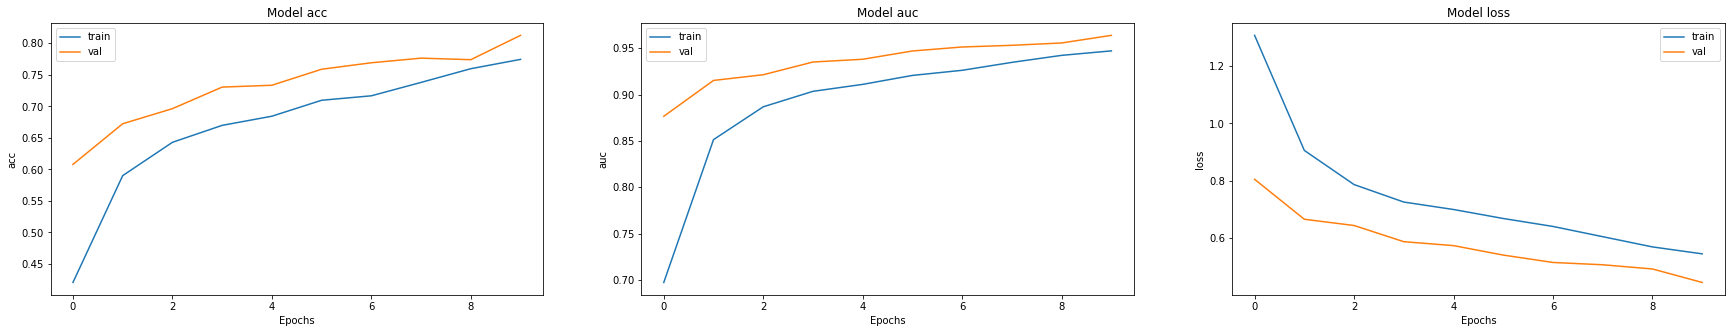

In [20]:
#Plotting the trend of the metrics during training
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()
for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [21]:
#Evaluating the model on the data
#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)
#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 38s 474ms/step - loss: 0.4662 - acc: 0.7977 - auc: 0.9599 - f1_score: 0.7978
Testing Accuracy: 79.77%


In [22]:
#Predicting the test data
pred_labels = custom_inception_model.predict(test_data)

80/80 [==============================] - 40s 493ms/step


In [23]:
#Print the classification report of the tested data
#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr
for labels in pred_labels:
    labels = roundoff(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.83      0.86      0.85       639
VeryMildDemented       0.99      1.00      1.00       635
    MildDemented       0.78      0.64      0.70       662
ModerateDemented       0.61      0.69      0.65       624

       micro avg       0.80      0.80      0.80      2560
       macro avg       0.80      0.80      0.80      2560
    weighted avg       0.80      0.80      0.80      2560
     samples avg       0.80      0.80      0.80      2560



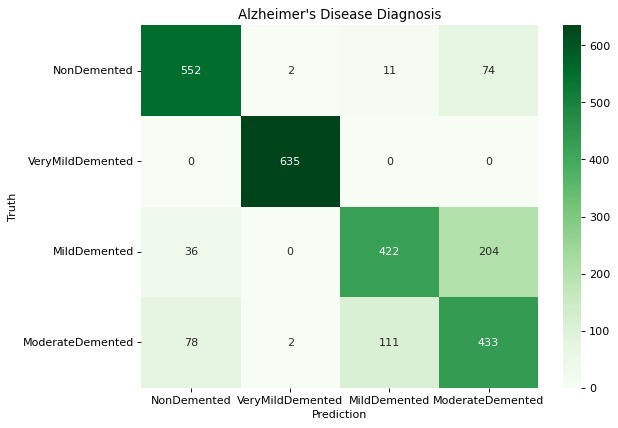

In [24]:
#Plot the confusion matrix to understand the classification in detail
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)
conf_arr = confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [68]:
df_pred = pd.DataFrame(pred_ls,columns=['Predicted'])

In [69]:
df_true = pd.DataFrame(test_ls,columns=['True'])

In [70]:
df_combined = pd.concat([df_true.reset_index(drop=True), df_pred], axis=1)

In [77]:
print(df_combined)

      True_Image_Classification  Predicted_Image_Classification
0                             3                               3
1                             1                               1
2                             2                               2
3                             3                               3
4                             2                               2
...                         ...                             ...
2555                          2                               2
2556                          1                               1
2557                          1                               1
2558                          2                               3
2559                          0                               0

[2560 rows x 2 columns]


In [79]:
df_combined['ID'] = np.arange(len(df_combined))
print (df_combined)

      True_Image_Classification  Predicted_Image_Classification    ID
0                             3                               3     0
1                             1                               1     1
2                             2                               2     2
3                             3                               3     3
4                             2                               2     4
...                         ...                             ...   ...
2555                          2                               2  2555
2556                          1                               1  2556
2557                          1                               1  2557
2558                          2                               3  2558
2559                          0                               0  2559

[2560 rows x 3 columns]


In [67]:
#Export Results to csv
df_combined.to_csv(r'C:\Users\DICOM\df_combined.csv', index = False)

In [25]:
#Printing some other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 79.88 %


In [27]:
#Saving the model for future use
custom_inception_model_dir = w_dir + "alzheimer_inception_cnn_model"
custom_inception_model.save(custom_inception_model_dir, save_format='h5')
os.listdir(w_dir)

['alzheimer_inception_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [32]:
pretrained_model = tf.keras.models.load_model(custom_inception_model_dir)
#Check its architecture
plot_model(pretrained_model, to_file=w_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [33]:
#Constructing a Convolutional Neural Network Architecture
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    return block

In [34]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    return block

In [35]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")
    return model

In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [39]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True           
my_callback = MyCallback()
#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
Final_Results_New=Final_Results.to_csv(index = False)

In [ ]:
from azure.storage.blob import BlobClient

In [ ]:
storage_connection_string='DefaultEndpointsProtocol=https;AccountName=olastorageac;AccountKey=muBELkgpBZbtf2tIpI1vod6f1cO5KglhQaVFZVhCOWQgoPzkOWkcrGAPYONsz1KGyzrwH5WMmEFiYj1lxEfZ0A==;EndpointSuffix=core.windows.net'
container_name = 'modeloutput'
dest_file_name = 'Final_Results_New.csv'

In [ ]:
blob_client = BlobClient.from_connection_string(storage_connection_string,container_name,dest_file_name)

In [ ]:
csv_content = Final_Results_New
blob_client.upload_blob(csv_content)